## 1. Load Processed Data

In [19]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import warnings

# Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# XGBoost
import xgboost as xgb

# SHAP for explainability
import shap

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


In [20]:
# Load processed data
with open('../data/processed/data_splits.pkl', 'rb') as f:
    data_splits = pickle.load(f)

X_train = data_splits['X_train']
X_val = data_splits['X_val']
X_test = data_splits['X_test']
y_train = data_splits['y_train']
y_val = data_splits['y_val']
y_test = data_splits['y_test']
feature_cols = data_splits['feature_cols']
scaler = data_splits['scaler']

print("Data loaded successfully!")
print("=" * 50)
print(f"Training samples:   {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples:       {len(X_test)}")
print(f"Number of features: {len(feature_cols)}")

Data loaded successfully!
Training samples:   276
Validation samples: 59
Test samples:       60
Number of features: 38


## 2. Baseline Model: Logistic Regression

Starting with a simple, interpretable baseline model.

In [21]:
# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_val)
y_pred_proba_lr = lr_model.predict_proba(X_val)[:, 1]

print("✓ Logistic Regression trained successfully!")

✓ Logistic Regression trained successfully!



Logistic Regression - Evaluation Results

Accuracy:  0.9492
Precision: 0.9490
Recall:    0.9492
F1-Score:  0.9488
ROC-AUC:   0.9868

Classification Report:
              precision    recall  f1-score   support

    On Track       0.95      0.97      0.96        40
     At Risk       0.94      0.89      0.92        19

    accuracy                           0.95        59
   macro avg       0.95      0.93      0.94        59
weighted avg       0.95      0.95      0.95        59



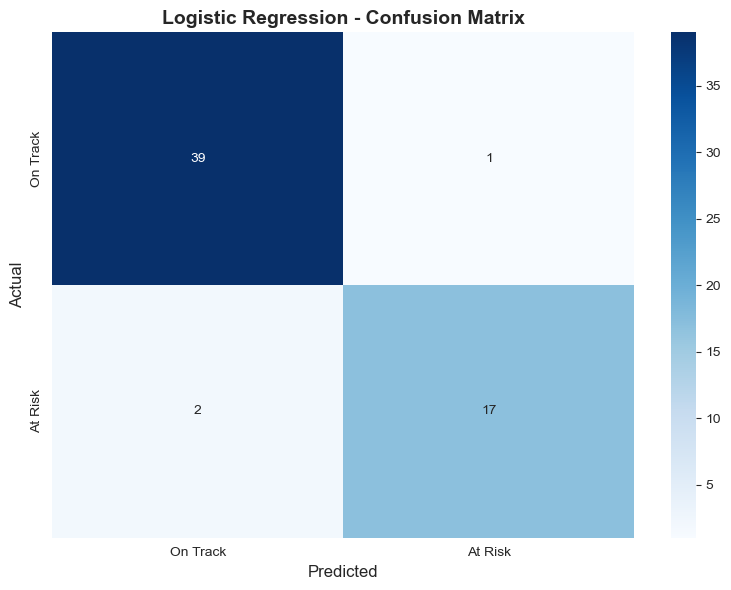

In [22]:
# Evaluate Logistic Regression
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Comprehensive model evaluation"""
    print(f"\n{'='*60}")
    print(f"{model_name} - Evaluation Results")
    print(f"{'='*60}\n")
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    # Print metrics
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['On Track', 'At Risk']))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['On Track', 'At Risk'],
                yticklabels=['On Track', 'At Risk'])
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

lr_metrics = evaluate_model(y_val, y_pred_lr, y_pred_proba_lr, "Logistic Regression")

## 3. Model 2: Random Forest

Ensemble method with built-in feature importance.

In [23]:
# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_val)
y_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]

print("✓ Random Forest trained successfully!")

✓ Random Forest trained successfully!



Random Forest - Evaluation Results

Accuracy:  0.9153
Precision: 0.9169
Recall:    0.9153
F1-Score:  0.9158
ROC-AUC:   0.9816

Classification Report:
              precision    recall  f1-score   support

    On Track       0.95      0.93      0.94        40
     At Risk       0.85      0.89      0.87        19

    accuracy                           0.92        59
   macro avg       0.90      0.91      0.90        59
weighted avg       0.92      0.92      0.92        59



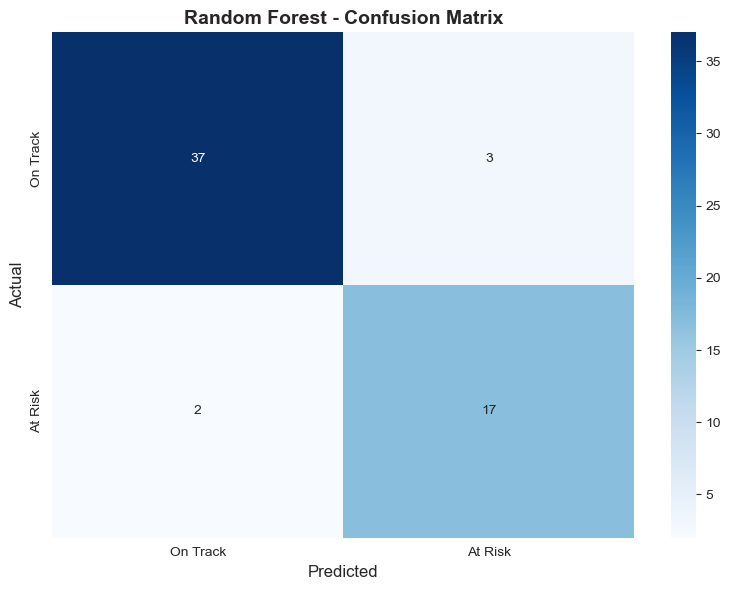

In [24]:
# Evaluate Random Forest
rf_metrics = evaluate_model(y_val, y_pred_rf, y_pred_proba_rf, "Random Forest")


Top 10 Most Important Features:
                   feature  importance
34  cumulative_performance    0.411541
31       performance_trend    0.125460
33       consistency_index    0.069982
5                 failures    0.038771
12                absences    0.033549
32        engagement_score    0.028668
8                    goout    0.020069
35           total_alcohol    0.019358
36        parent_education    0.016119
0                      age    0.015389


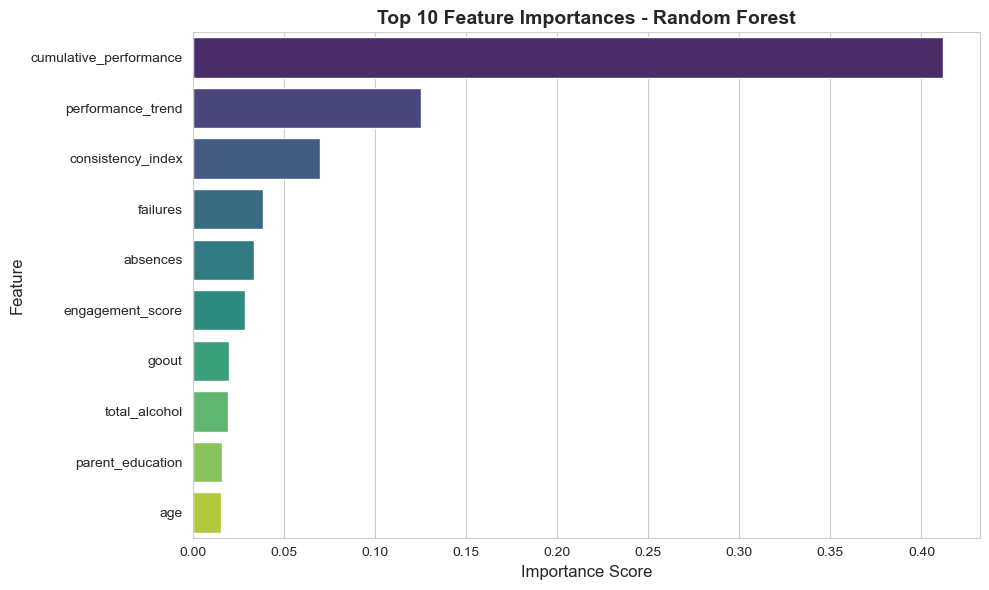

In [25]:
# Feature Importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print("=" * 50)
print(feature_importance.head(10))

# Visualize
plt.figure(figsize=(10, 6))
top_n = 10
sns.barplot(data=feature_importance.head(top_n), x='importance', y='feature', palette='viridis')
plt.title(f'Top {top_n} Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

## 4. Model 3: XGBoost

State-of-the-art gradient boosting for best performance.

In [26]:
# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train, verbose=False)

# Predictions
y_pred_xgb = xgb_model.predict(X_val)
y_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

print("✓ XGBoost trained successfully!")

✓ XGBoost trained successfully!



XGBoost - Evaluation Results

Accuracy:  0.9661
Precision: 0.9677
Recall:    0.9661
F1-Score:  0.9656
ROC-AUC:   0.9934

Classification Report:
              precision    recall  f1-score   support

    On Track       0.95      1.00      0.98        40
     At Risk       1.00      0.89      0.94        19

    accuracy                           0.97        59
   macro avg       0.98      0.95      0.96        59
weighted avg       0.97      0.97      0.97        59



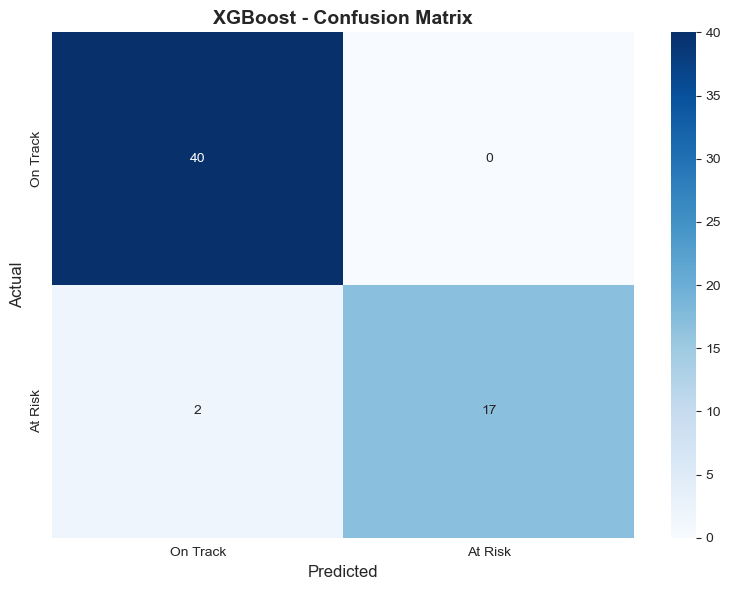

In [27]:
# Evaluate XGBoost
xgb_metrics = evaluate_model(y_val, y_pred_xgb, y_pred_proba_xgb, "XGBoost")

## 5. Model Comparison

Compare all models to select the best performer.

In [28]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_metrics['accuracy'], rf_metrics['accuracy'], xgb_metrics['accuracy']],
    'Precision': [lr_metrics['precision'], rf_metrics['precision'], xgb_metrics['precision']],
    'Recall': [lr_metrics['recall'], rf_metrics['recall'], xgb_metrics['recall']],
    'F1-Score': [lr_metrics['f1_score'], rf_metrics['f1_score'], xgb_metrics['f1_score']],
    'ROC-AUC': [lr_metrics['roc_auc'], rf_metrics['roc_auc'], xgb_metrics['roc_auc']]
})

print("\nModel Comparison:")
print("=" * 100)
print(comparison_df.to_string(index=False))

# Highlight best model
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Model (by F1-Score): {best_model_name}")


Model Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.949153   0.949038 0.949153  0.948779 0.986842
      Random Forest  0.915254   0.916927 0.915254  0.915804 0.981579
            XGBoost  0.966102   0.967716 0.966102  0.965573 0.993421

🏆 Best Model (by F1-Score): XGBoost


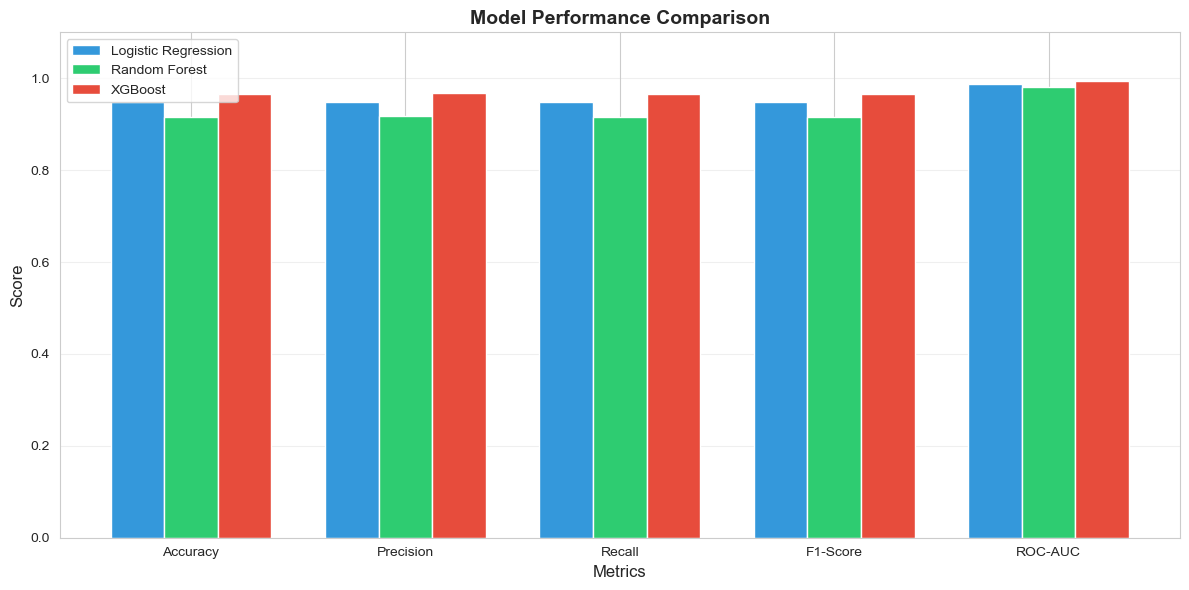

In [29]:
# Visualize comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics_to_plot))
width = 0.25

ax.bar(x - width, comparison_df.iloc[0][metrics_to_plot].values, width, label='Logistic Regression', color='#3498db')
ax.bar(x, comparison_df.iloc[1][metrics_to_plot].values, width, label='Random Forest', color='#2ecc71')
ax.bar(x + width, comparison_df.iloc[2][metrics_to_plot].values, width, label='XGBoost', color='#e74c3c')

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

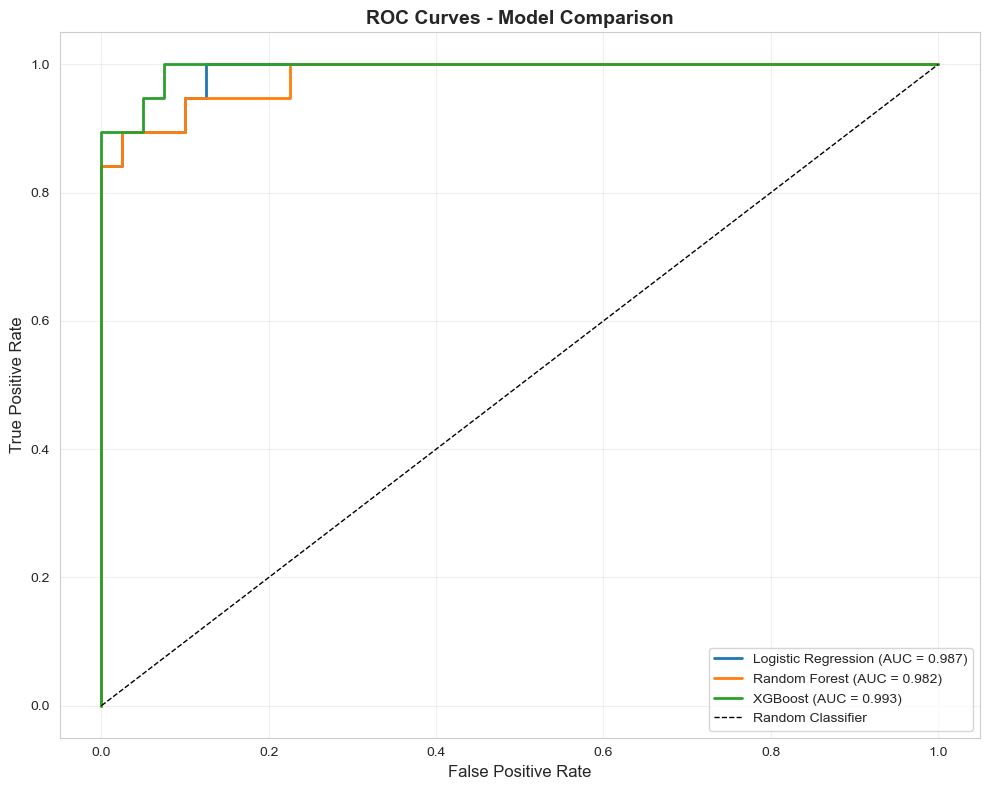

In [30]:
# ROC Curve comparison
plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_metrics["roc_auc"]:.3f})', linewidth=2)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_metrics["roc_auc"]:.3f})', linewidth=2)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_metrics["roc_auc"]:.3f})', linewidth=2)

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Model Explainability (SHAP)

Using SHAP values to explain the best model's predictions.

In [31]:
# Select best model for SHAP analysis
if best_model_name == 'Logistic Regression':
    best_model = lr_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
else:
    best_model = xgb_model

print(f"Generating SHAP values for {best_model_name}...")

# Create SHAP explainer
# Use a sample for faster computation
sample_size = min(100, len(X_train))
X_sample = X_train.sample(n=sample_size, random_state=42)

if best_model_name == 'Logistic Regression':
    explainer = shap.LinearExplainer(best_model, X_sample)
else:
    explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_sample)

print("✓ SHAP values computed!")

Generating SHAP values for XGBoost...
✓ SHAP values computed!


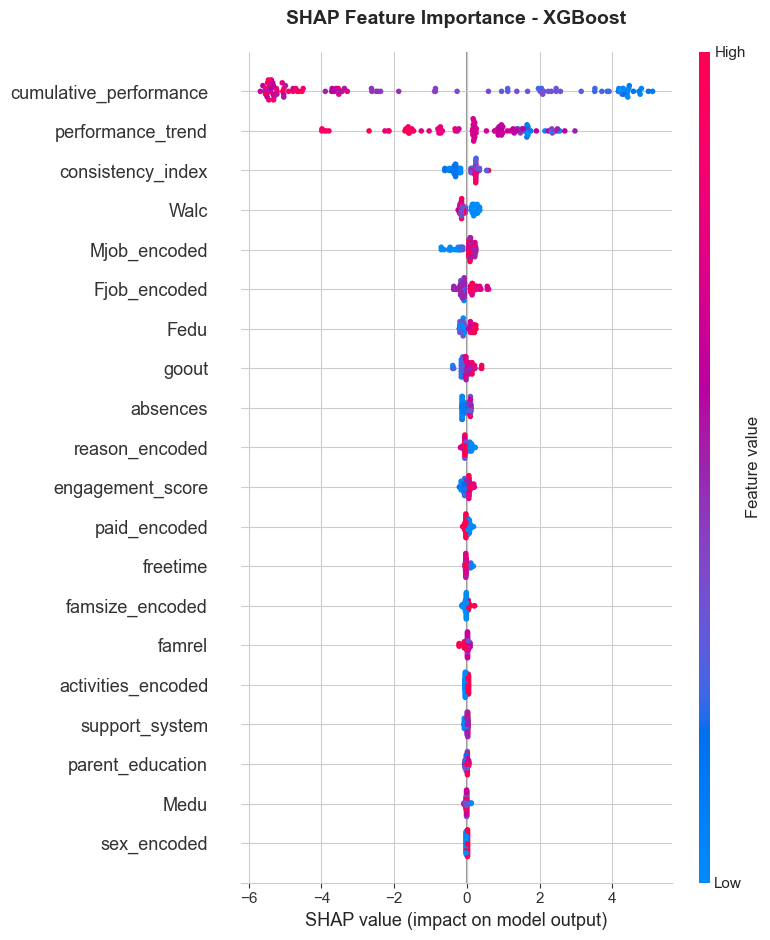

In [32]:
# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False)
plt.title(f'SHAP Feature Importance - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 7. Save Best Model


FINAL EVALUATION ON TEST SET

XGBoost (Test Set) - Evaluation Results

Accuracy:  0.9833
Precision: 0.9841
Recall:    0.9833
F1-Score:  0.9834
ROC-AUC:   0.9988

Classification Report:
              precision    recall  f1-score   support

    On Track       1.00      0.97      0.99        40
     At Risk       0.95      1.00      0.98        20

    accuracy                           0.98        60
   macro avg       0.98      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60



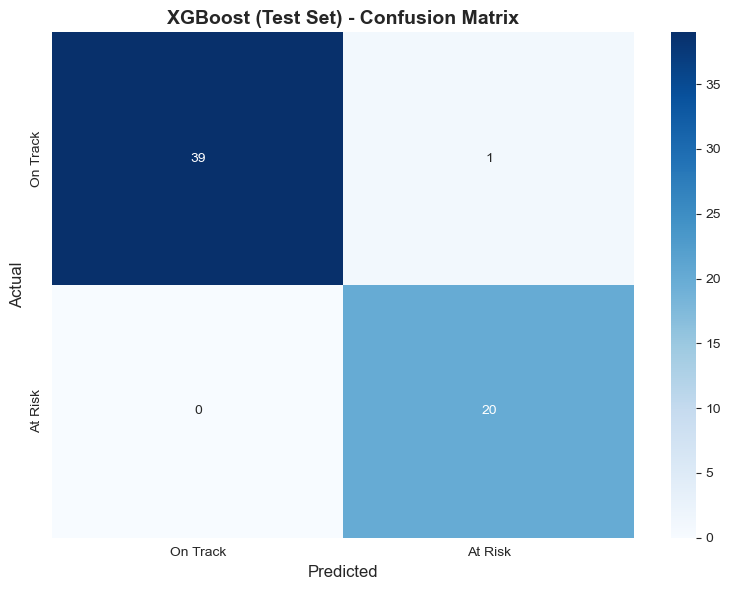

In [33]:
# Final evaluation on test set
print("\n" + "="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

y_pred_test = best_model.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

final_metrics = evaluate_model(y_test, y_pred_test, y_pred_proba_test, f"{best_model_name} (Test Set)")

In [34]:
# Save the best model
model_package = {
    'model': best_model,
    'model_name': best_model_name,
    'scaler': scaler,
    'feature_cols': feature_cols,
    'metrics': final_metrics,
    'label_encoders': data_splits.get('label_encoders', {})
}

# Save as pickle
with open('../models/best_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("\n✓ Model saved to: ../models/best_model.pkl")

# Also save as joblib (more efficient for large models)
joblib.dump(model_package, '../models/best_model.joblib')
print("✓ Model saved to: ../models/best_model.joblib")


✓ Model saved to: ../models/best_model.pkl
✓ Model saved to: ../models/best_model.joblib


In [35]:
# Save model metadata
metadata = {
    'model_name': best_model_name,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_features': len(feature_cols),
    'feature_names': feature_cols,
    'metrics': {
        'test_accuracy': final_metrics['accuracy'],
        'test_precision': final_metrics['precision'],
        'test_recall': final_metrics['recall'],
        'test_f1_score': final_metrics['f1_score'],
        'test_roc_auc': final_metrics['roc_auc']
    },
    'hyperparameters': best_model.get_params()
}

import json
with open('../models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✓ Metadata saved to: ../models/model_metadata.json")

✓ Metadata saved to: ../models/model_metadata.json


---

## Summary

**Completed Tasks:**
- ✓ Trained 3 classification models:
  - Logistic Regression (baseline)
  - Random Forest (ensemble)
  - XGBoost (gradient boosting)
- ✓ Evaluated all models using comprehensive metrics:
  - Accuracy, Precision, Recall, F1-Score, ROC-AUC
  - Confusion matrices
  - ROC curves
- ✓ Performed model comparison
- ✓ Generated SHAP values for model explainability
- ✓ Selected best model based on F1-Score
- ✓ Evaluated best model on test set
- ✓ Saved model and metadata

**Best Model:** {best_model_name}
- **Test Accuracy:** {final_metrics['accuracy']:.4f}
- **Test F1-Score:** {final_metrics['f1_score']:.4f}
- **Test ROC-AUC:** {final_metrics['roc_auc']:.4f}

**Next Step:** Proceed to API development in `api/main.py`

In [36]:
# Print final summary
print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)
print(f"\nBest Model: {best_model_name}")
print(f"Test Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Test F1-Score: {final_metrics['f1_score']:.4f}")
print(f"Test ROC-AUC:  {final_metrics['roc_auc']:.4f}")
print(f"\nModel saved and ready for deployment!")


MODEL TRAINING COMPLETE!

Best Model: XGBoost
Test Accuracy: 0.9833
Test F1-Score: 0.9834
Test ROC-AUC:  0.9988

Model saved and ready for deployment!
